In [ ]:
  
# SKT Brain의 KoBERT, 학습 및 테스트 데이터셋만 따로 준비 = 카카오 브런치[text, label]
# SKT Brain github 주소는 다음과 같습니다. https://github.com/SKTBrain/KoBERT

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2 # 최신 버전으로 설치하면 "Input: must be Tensor, not str" 라는 에러 발생
!pip install torch

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

     |████████████████████████████████| 46.9 MB 1.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 4.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595716 sha256=1d5a51cfded48fcc8e5f4fb9d7914f22b343baca2b5e73fd56cd7335d16983c1
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 4.3 MB/s 
     |████████████████████████████████| 769 kB 4.2 MB/s 
     |████████████████████████████████| 3.0 MB 57.0 MB/s 
     |████████████████████████████████| 895 kB 70.1 MB/s 
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-y40c3nkc
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pi

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
# GPU 사용 시
device = torch.device("cuda:0")

# BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

.cache/kobert_v1.zip[██████████████████████████████████████████████████]
.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터셋 불러오기
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/데캡디/train_aug_sr.csv')
test = pd.read_csv('/content/drive/MyDrive/데캡디/test_augX.csv')

In [ ]:
# data 확인
train.head()

,Unnamed: 0,review,label
0,999,무난무난한 수분크림 세일해서 저렴하게 샀네요~~!! 잘 쓸게요ㅔ,0
1,1186,구 집에서 우연히 처음 쓰게 됐는데 너무 좋더라구요. 사 날은 토너밖에 못 발랐는데...,1
2,1151,"제 피부 타입은, 민감 복합성 입니다. 그리고 트러블이 있는 피부입니다 ㅠㅠ 근 1...",1
3,263,"아비브제품은 말 할 것도 없이 다 좋아요! 스킨부스터도 좋은데, 저렴하지는 않아서 ...",0
4,931,❣️보습력 굳굳 ❣️순한 토너 ❣️진정효과 탁월 저는 지성에다 여드름성 초예민 피부...,1


In [ ]:
train['label'].value_counts()

1    1365
0    1365
Name: label, dtype: int64

In [ ]:
test['label'].value_counts()

1    110
0    110
Name: label, dtype: int64

In [ ]:
train = train[ ['review', 'label'] ]
test = test[ ['review', 'label'] ]

In [ ]:
'''
# column명 변경
data.rename(columns={'document':'content', 'spo_label':'label'}, inplace=True)

# type 변경
data = data.astype({'label':'object'})
data.info()
'''

# column명 변경
train.rename(columns={'review':'content', 'label':'label'}, inplace=True)
# type 변경
train = train.astype({'label':'object'})
train.info()

# column명 변경
test.rename(columns={'review':'content', 'label':'label'}, inplace=True)
# type 변경
test = test.astype({'label':'object'})
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2730 non-null   object
 1   label    2730 non-null   object
dtypes: object(2)
memory usage: 42.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  220 non-null    object
 1   label    220 non-null    object
dtypes: object(2)
memory usage: 3.6+ KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train = train.astype({'label':'int'})
train.info()

test = test.astype({'label':'int'})
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2730 non-null   object
 1   label    2730 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  220 non-null    object
 1   label    220 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


In [ ]:
new_data_train = train
new_data_train.info()

new_data_test = test
new_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2730 non-null   object
 1   label    2730 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  220 non-null    object
 1   label    220 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


In [ ]:
'''
# label encoding
new_data.loc[(new_data['label'] == "0"), 'label'] = 0  # spoX => 0
new_data.loc[(new_data['label'] == "1"), 'label'] = 1  # spo => 1


# list형태로 데이터 저장 -> [content, label] 형태
data_list = []
for q, label in zip(new_data['content'], new_data['label'])  :
    data = []
    data.append(str(q)) # str타입으로 변환, 안 해주면 나중에 타입변환할 때 오류남
    data.append(str(label))

    data_list.append(data)
'''

# label encoding
new_data_train.loc[(new_data_train['label'] == "0"), 'label'] = 0  # spoX => 0
new_data_train.loc[(new_data_train['label'] == "1"), 'label'] = 1  # spo => 1
# list형태로 데이터 저장 -> [content, label] 형태
dataset_train = []
for q, label in zip(new_data_train['content'], new_data_train['label'])  :
    data = []
    data.append(str(q)) # str타입으로 변환, 안 해주면 나중에 타입변환할 때 오류남
    data.append(str(label))

    dataset_train.append(data)

# label encoding
new_data_test.loc[(new_data_test['label'] == "0"), 'label'] = 0  # spoX => 0
new_data_test.loc[(new_data_test['label'] == "1"), 'label'] = 1  # spo => 1
# list형태로 데이터 저장 -> [content, label] 형태
dataset_test = []
for q, label in zip(new_data_test['content'], new_data_test['label'])  :
    data = []
    data.append(str(q)) # str타입으로 변환, 안 해주면 나중에 타입변환할 때 오류남
    data.append(str(label))

    dataset_test.append(data)

In [ ]:
# 데이터 확인
print(dataset_train[0])
print(dataset_test[-1])

['무난무난한 수분크림 세일해서 저렴하게 샀네요~~!! 잘 쓸게요ㅔ', '0']
['1. 너무 촉촉해요 약간의 광이 나면서 깊숙히 보습되는 느낌이에요 저는 건조함 1도 싫어해서 오일에 섞어 바르는데 바르고 반나절이 지나도 건조함이 없어요 건성인 분들은 단독으로는 보습이 모자랄 수 있어 오일 조합 추천드려요  2. 촉촉한거 말고는 다른 효과는 모르겠어요 하지만 전 수분공급 기능만으로 아주 만족합니다 유분기가 있는건 아니라 지성분들도 써도 될듯해요  * 크림에 알갱이들이 있는데 체온에 완전 녹지는 않아서  얼굴에 좁쌀처럼 몇개씩 붙어있어요.  위에 화장할때 툭툭 털어주고 시작해요 그래도 흡수는 잘돼서 화장이 밀리지 않아요 ', '1']


In [ ]:
'''
# train, test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)
'''

'\n# train, test 데이터로 나누기\nfrom sklearn.model_selection import train_test_split\n                                                         \ndataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)\n'

In [ ]:
# 데이터 개수 확인
print(len(dataset_train))
print(len(dataset_test))

2730
220


In [ ]:
# KoBERT모델의 입력으로 들어갈 수 있는 형태가 되도록 변환해주는 class
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        # BERTSentenceTransform이라는 모듈 사용
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        # 타입 변환
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    # item 가져오기
    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    # 길이 출력
    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 64
batch_size = 16
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate =  1e-6

In [ ]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# 패딩
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model


In [ ]:
# 데이터 확인 -> array1은 시퀀스, array2는 길이와 타입, array3은 attention mask 시퀀스(1로 패딩된 값들은 연산할 필요가 없기 때문에, 연산을 하지 않아도 됨 -> 이걸 알려주는 데이터가 바로 얘)
data_train[0]

(array([   2, 2095, 5663, 6228, 5663, 7828, 2872, 6416, 7565, 6136, 2801,
        7126, 7850, 3992, 7784,  517, 6526, 5703,  517,  463,  517,  463,
         517,    5,  517,    5, 3942, 3087, 5400, 6999,    0,    3,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(32, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [ ]:
# torch 형식의 dataset 생성
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# KoBERT 학습모델
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,   # 클래스 수 조정
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio) # 초기에 성능을 끌어올리는 것 = 운동할 때 워밍업 느낌

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# 정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0] # 맞은 비율
    return train_acc
    
train_dataloader

In [ ]:
# 모델 학습시키기
train_loss_list = []
#test_loss_list = []
train_acc_list = []
test_acc_list = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_loss_list.append(loss.data.cpu().numpy())
    train_acc_list.append(train_acc/(batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc/(batch_id+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/171 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 0.6262019276618958 train acc 0.5625
epoch 1 train acc 0.581140350877193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 1 test acc 0.6220238095238095


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6707863807678223 train acc 0.5
epoch 2 train acc 0.6300438596491228


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 2 test acc 0.71875


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.6732842922210693 train acc 0.625
epoch 3 train acc 0.7248538011695906


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 3 test acc 0.806547619047619


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5395188331604004 train acc 0.75
epoch 4 train acc 0.8010964912280703


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 4 test acc 0.8363095238095238


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.41377130150794983 train acc 0.9375
epoch 5 train acc 0.828874269005848


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 5 test acc 0.8363095238095238


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.3395106792449951 train acc 0.9375
epoch 6 train acc 0.8504385964912281


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 6 test acc 0.8407738095238095


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.34052085876464844 train acc 0.875
epoch 7 train acc 0.8701754385964913


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 7 test acc 0.8303571428571429


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.26570168137550354 train acc 0.9375
epoch 8 train acc 0.8778508771929825


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 8 test acc 0.8318452380952381


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.22929029166698456 train acc 0.9375
epoch 9 train acc 0.8894005847953217


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 9 test acc 0.8169642857142857


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.20113472640514374 train acc 1.0
epoch 10 train acc 0.9116959064327486


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 10 test acc 0.8125


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.19701960682868958 train acc 1.0
epoch 11 train acc 0.910233918128655


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 11 test acc 0.8258928571428571


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.27108797430992126 train acc 0.9375
epoch 12 train acc 0.9241228070175439


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 12 test acc 0.8125


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.15332376956939697 train acc 1.0
epoch 13 train acc 0.9248538011695907


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 13 test acc 0.8080357142857143


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.2037207931280136 train acc 0.9375
epoch 14 train acc 0.9321637426900585


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 14 test acc 0.8214285714285714


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.16108529269695282 train acc 0.9375
epoch 15 train acc 0.9321637426900585


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 15 test acc 0.7991071428571429


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.16845205426216125 train acc 1.0
epoch 16 train acc 0.9380116959064327


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 16 test acc 0.8080357142857143


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.1171531230211258 train acc 1.0
epoch 17 train acc 0.9350877192982456


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 17 test acc 0.7991071428571429


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.11230754852294922 train acc 1.0
epoch 18 train acc 0.9365497076023392


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 18 test acc 0.7991071428571429


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.1554117649793625 train acc 0.9375
epoch 19 train acc 0.9387426900584795


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 19 test acc 0.7991071428571429


  0%|          | 0/171 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.13520658016204834 train acc 1.0
epoch 20 train acc 0.933625730994152


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 20 test acc 0.7991071428571429


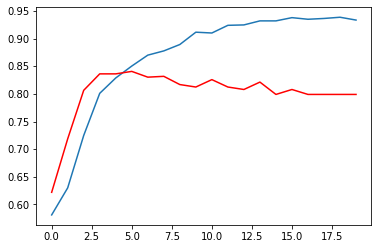

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0.0, 20.0, 1.0), train_acc_list, np.arange(0.0, 20.0, 1.0), test_acc_list, 'r-')

In [ ]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# 새로운 문장 테스트
def predict(predict_sentence):
  data = [predict_sentence, '0']
  dataset_another = [data]

  another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
      token_ids = token_ids.long().to(device)
      print("token_ids : ", token_ids)
      segment_ids = segment_ids.long().to(device)
      print("segment_ids : ", segment_ids)

      valid_length= valid_length
      print("valid_length : ", valid_length)
      label = label.long().to(device)
      print("label : ", label)
      out = model(token_ids, valid_length, segment_ids)

      print("out : ", out)

      test_eval=[]
      for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()
          print("logits : ", logits)

          if np.argmax(logits) == 0:
                test_eval.append("유용x")
          elif np.argmax(logits) == 1:
                test_eval.append("유용")
        

      print(">> 이 리뷰는 " + test_eval[0] + "합니다.")

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("리뷰를 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

리뷰를 입력해주세요 : 배달 빠르고 좋네요


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


token_ids :  tensor([[   2, 2287, 5793, 2556, 4204, 5703,    3,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1]], device='cuda:0')
segment_ids :  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
valid_length :  tensor([7], dtype=torch.int32)
label :  tensor([0], device='cuda:0')
out :  tensor([[ 1.4825, -1.1941]], device='cuda:0', grad_fn=<AddmmBackward0>)
logits :  [ 1.4824896 -1.1940782]
>> 이 리뷰는 유용x합니다.


리뷰를 입력해주세요 : 수분감도 촉촉하고 피부도 매끄러워져요
token_ids :  tensor([[   2

KeyboardInterrupt: ignored